# Cats Vs. Dogs 데이터 CNN 실험


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Found 2000 files belonging to 2 classes.
(5, 150, 150, 3)
(5, 1)


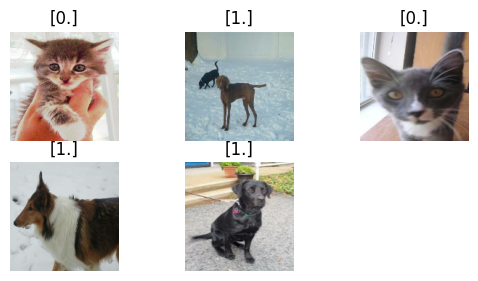

In [2]:
#학습 데이터 읽기
train_dir = "data/cats_vs_dogs_small/train"

train_ds = keras.utils.image_dataset_from_directory (
    train_dir,
    label_mode="binary",
    color_mode="rgb",
    image_size=(150, 150),
    batch_size=5,
    shuffle=True
)

for trainX, trainY in train_ds.take(1):
    print(trainX.shape)
    print(trainY.shape)

    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(trainX[i].numpy().astype(np.uint8))
        plt.title(trainY[i].numpy())
        plt.axis("off")

Found 2000 files belonging to 2 classes.
(5, 150, 150, 3)
(5, 1)


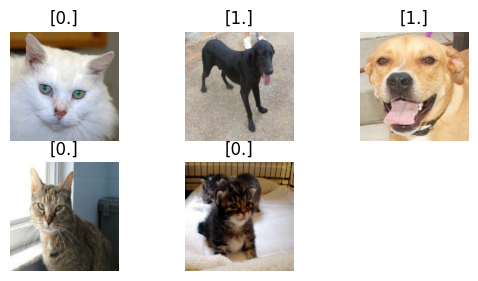

In [3]:
#검증 데이터
test_dir = "data/cats_vs_dogs_small/test"

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    color_mode="rgb",
    image_size=(150, 150),
    batch_size=5,
    shuffle=True
)

#???
for testX, testY in test_ds.take(1):
    print(testX.shape)
    print(testY.shape)

    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(testX[i].numpy().astype(np.uint8))
        plt.title(testY[i].numpy())
        plt.axis("off")

## 모델 설정 (1) : Flatten 먼저

In [4]:
inputs = keras.Input(shape=(150, 150, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="softplus")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17    

### 모델(1) 컴파일

In [5]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath="CNNmodel/catdog_model1.hdf5", monitor="val_loss", save_best_only=True, verbose=1)
#earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy", metrics=["accuracy"])
history = model1.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[checkpoint])


Epoch 1/30


400/400 [==============================] - ETA: 0s - loss: 70.4521 - accuracy: 0.5305
Epoch 1: val_loss improved from inf to 36.70246, saving model to CNNmodel\catdog_model1.hdf5
400/400 [==============================] - 29s 71ms/step - loss: 70.4521 - accuracy: 0.5305 - val_loss: 36.7025 - val_accuracy: 0.5375
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 59.7901 - accuracy: 0.5145
Epoch 2: val_loss improved from 36.70246 to 35.45975, saving model to CNNmodel\catdog_model1.hdf5
400/400 [==============================] - 28s 70ms/step - loss: 59.7901 - accuracy: 0.5145 - val_loss: 35.4597 - val_accuracy: 0.5160
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 22.0308 - accuracy: 0.5570
Epoch 3: val_loss improved from 35.45975 to 21.55698, saving model to CNNmodel\catdog_model1.hdf5
400/400 [==============================] - 29s 71ms/step - loss: 22.0308 - accuracy: 0.5570 - val_loss: 21.5570 - val_accuracy: 0.5200
Epoch 4/30
400/400 [======

0.6922318339347839
0.6430000066757202
0.698396623134613
0.5720000267028809
        loss  accuracy   val_loss  val_accuracy
0  70.452087    0.5305  36.702461        0.5375
1  59.790092    0.5145  35.459747        0.5160
2  22.030767    0.5570  21.556980        0.5200
3   9.937178    0.6165   6.063823        0.5330
4  15.360486    0.5960  88.045891        0.5040


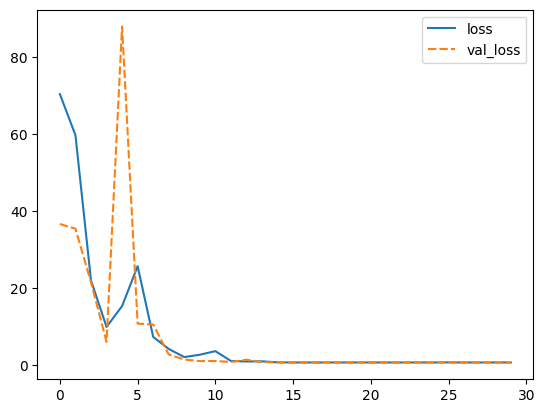

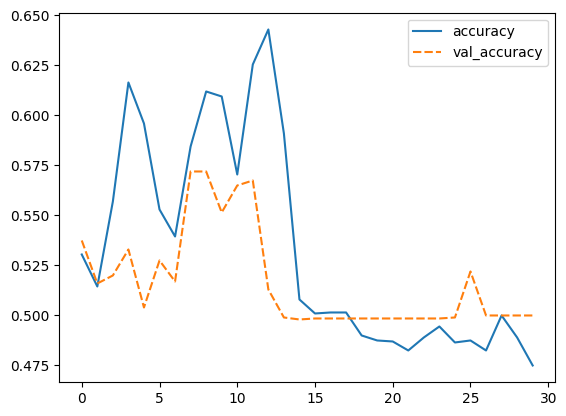

In [6]:
print(min(history.history["loss"]))
print(max(history.history["accuracy"]))
print(min(history.history["val_loss"]))
print(max(history.history["val_accuracy"]))

df_result = pd.DataFrame(history.history)
print(df_result.head())

sns.lineplot(df_result[["loss", "val_loss"]])
plt.show()

sns.lineplot(df_result[["accuracy", "val_accuracy"]])
plt.show()

## 모델 설정 (2) : CNN

In [22]:
inputs = keras.Input(shape=(150, 150, 3))
x = layers.Rescaling(1 / 255.0)(inputs)
x = layers.Conv2D(64, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(32)(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation("sigmoid")(x)

model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_22 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        18464     
                                                           

### 모델(2) 컴파일 및 실행

In [23]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath="CNNmodel/catdog_model2.hdf5", monitor="val_loss", save_best_only=True, verbose=1)

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy", metrics=["accuracy"])
history2 = model2.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[checkpoint])


Epoch 1/30


400/400 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5085
Epoch 1: val_loss improved from inf to 0.69130, saving model to CNNmodel\catdog_model2.hdf5
400/400 [==============================] - 38s 92ms/step - loss: 0.6945 - accuracy: 0.5085 - val_loss: 0.6913 - val_accuracy: 0.6020
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.5660
Epoch 2: val_loss improved from 0.69130 to 0.65482, saving model to CNNmodel\catdog_model2.hdf5
400/400 [==============================] - 35s 88ms/step - loss: 0.6790 - accuracy: 0.5660 - val_loss: 0.6548 - val_accuracy: 0.6470
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6250
Epoch 3: val_loss improved from 0.65482 to 0.63610, saving model to CNNmodel\catdog_model2.hdf5
400/400 [==============================] - 35s 88ms/step - loss: 0.6505 - accuracy: 0.6250 - val_loss: 0.6361 - val_accuracy: 0.6550
Epoch 4/30
400/400 [====================

       loss  accuracy  val_loss  val_accuracy
0  0.694453    0.5085  0.691297        0.6020
1  0.679018    0.5660  0.654823        0.6470
2  0.650520    0.6250  0.636095        0.6550
3  0.609060    0.6765  0.597935        0.6760
4  0.560174    0.7145  0.604963        0.6695
0.7505000233650208


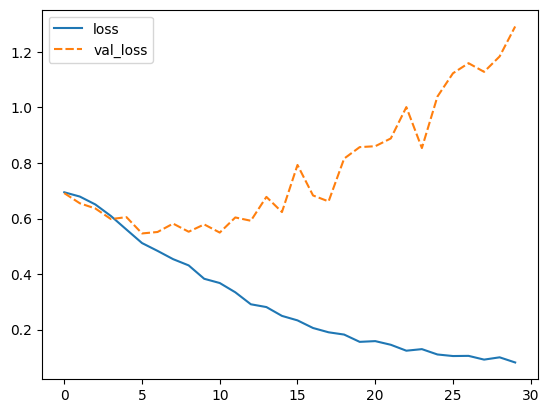

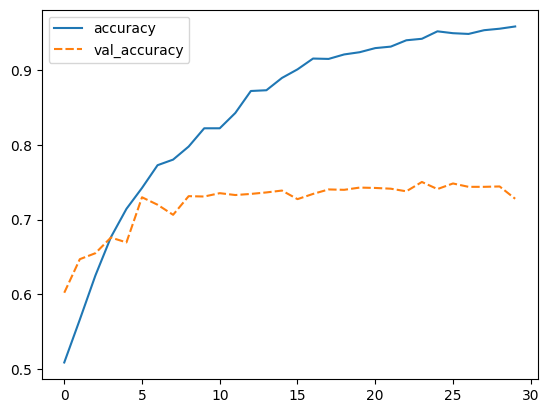

In [24]:
df_result = pd.DataFrame(history2.history)
print(df_result.head())
print(max(history2.history["val_accuracy"]))

sns.lineplot(df_result[["loss", "val_loss"]])
plt.show()

sns.lineplot(df_result[["accuracy", "val_accuracy"]])
plt.show()

---

## 모델(3) 설정 : data 증식 사용

Found 2000 images belonging to 2 classes.
(5, 150, 150, 3)
(5,)


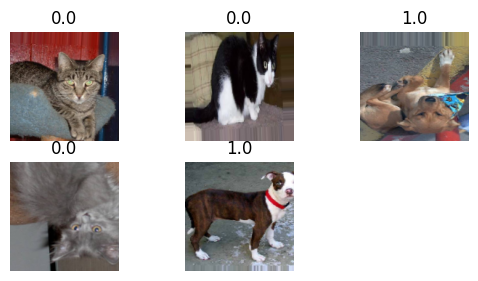

In [10]:
#dataGenerator

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip =   True,
    vertical_flip =     True,
    width_shift_range = 0.1,
    height_shift_range= 0.1,
    rotation_range =    5,
    zoom_range=         0.2,
    
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=5,
    class_mode="binary"
)

for trainX, trainY in train_generator:
    print(trainX.shape)
    print(trainY.shape)

    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(trainX[i])
        plt.title(trainY[i])
        plt.axis("off")
    
    break

Found 2000 images belonging to 2 classes.
(5, 150, 150, 3)
(5,)


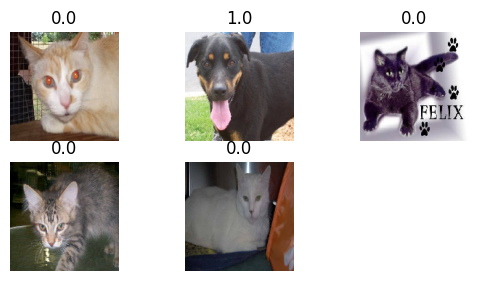

In [11]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=5,
    class_mode="binary"
)

for trainX, trainY in test_generator:
    print(trainX.shape)
    print(trainY.shape)

    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(trainX[i])
        plt.title(trainY[i])
        plt.axis("off")
    
    break

In [12]:
inputs = keras.Input(shape=(150, 150, 3))
x = layers.Rescaling(1 / 255.0)(inputs)
x = layers.Conv2D(32, kernel_size=(3, 3))(inputs)
#x = layers.Conv2D(32, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(64)(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
outputs = layers.Activation("sigmoid")(x)

model3 = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath="CNNmodel/catdog_model3.hdf5", monitor="val_loss", save_best_only=True, verbose=1)
earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss="binary_crossentropy", metrics=["accuracy"])
#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[checkpoint])
history = model3.fit(train_generator, validation_data=test_generator, epochs=30, callbacks=[checkpoint])

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5180
Epoch 1: val_loss improved from inf to 0.67901, saving model to CNNmodel\catdog_model3.hdf5
400/400 [==============================] - 23s 56ms/step - loss: 0.6924 - accuracy: 0.5180 - val_loss: 0.6790 - val_accuracy: 0.5780
Epoch 2/30
399/400 [============================>.] - ETA: 0s - loss: 0.6786 - accuracy: 0.5820
Epoch 2: val_loss improved from 0.67901 to 0.65725, saving model to CNNmodel\catdog_model3.hdf5
400/400 [==============================] - 23s 58ms/step - loss: 0.6791 - accuracy: 0.5810 - val_loss: 0.6572 - val_accuracy: 0.6295
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6125
Epoch 3: val_loss improved from 0.65725 to 0.62012, saving model to CNNmodel\catdog_model3.hdf5
400/400 [==============================] - 23s 58ms/step - loss: 0.6470 - accuracy: 0.6125 - val_loss: 0.6201 - val_accuracy: 0.6645
Epoch 4/30
399/400 [=========

       loss  accuracy  val_loss  val_accuracy
0  0.692412    0.5180  0.679013        0.5780
1  0.679129    0.5810  0.657250        0.6295
2  0.647044    0.6125  0.620120        0.6645
3  0.631200    0.6460  0.599549        0.6760
4  0.612419    0.6575  0.593721        0.6850
0.7519999742507935


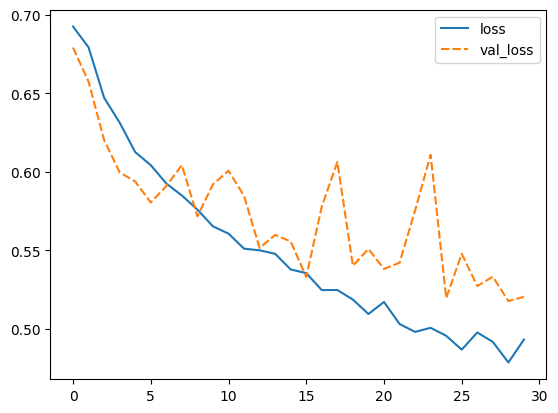

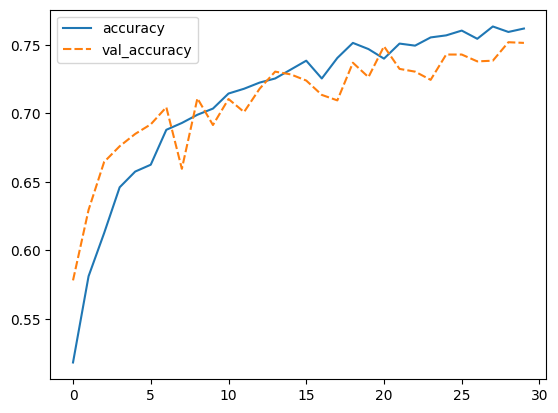

In [25]:
df_result = pd.DataFrame(history.history)
print(df_result.head())
print(max(history.history["val_accuracy"]))

sns.lineplot(df_result[["loss", "val_loss"]])
plt.show()

sns.lineplot(df_result[["accuracy", "val_accuracy"]])
plt.show()